In [64]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
import zipfile
import os

# Zip dosyasının olduğu yolu belirle (önceki adımdan aldığın yolu buraya yaz)
zip_path = "/content/drive/My Drive/MEDI-4.zip"

# Çıkarılacak klasörün yolu
extract_path = "/content/MEDI-4"

# Zip dosyasını aç ve içeriğini çıkart
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Dosyaların çıkarıldığını kontrol et
print("Dosyalar çıkarıldı. Klasör içeriği:")
print(os.listdir(extract_path))


Dosyalar çıkarıldı. Klasör içeriği:
['MEDI-4']


In [67]:
!pip install pynrrd


In [68]:
import nrrd

# NRRD dosyalarının tam yolunu belirle
scan_path = os.path.join(extract_path, "MEDI-4", "MEDI-4(SCAN).nrrd")
mask_path = os.path.join(extract_path, "MEDI-4", "MEDI-4(MASK).nrrd")

# Dosyaları oku
scan_data, _ = nrrd.read(scan_path)
mask_data, _ = nrrd.read(mask_path)

# Veri boyutlarını kontrol et
print("Scan Data Shape:", scan_data.shape)
print("Mask Data Shape:", mask_data.shape)


Scan Data Shape: (512, 512, 129)
Mask Data Shape: (512, 512, 129)


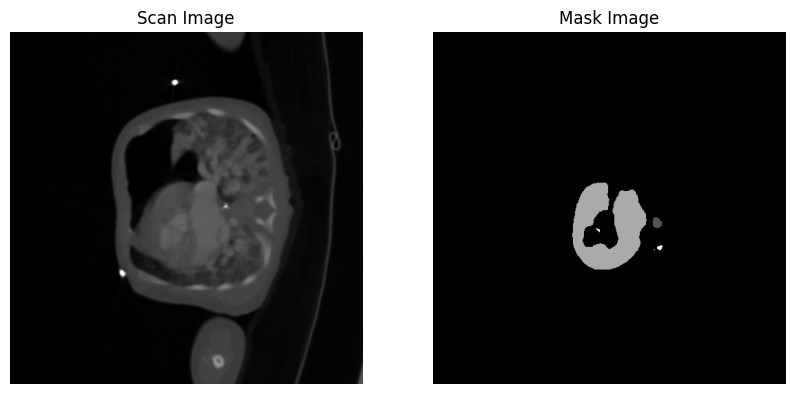

In [69]:
import matplotlib.pyplot as plt

# Orta seviyeden bir dilim seç
slice_index = scan_data.shape[2] // 2

# Görüntüyü ve maskeyi çiz
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Tarama görüntüsü
axes[0].imshow(scan_data[:, :, slice_index], cmap="gray")
axes[0].set_title("Scan Image")
axes[0].axis("off")

# Mask görüntüsü
axes[1].imshow(mask_data[:, :, slice_index], cmap="gray")
axes[1].set_title("Mask Image")
axes[1].axis("off")

plt.show()


In [115]:
import os
import pandas as pd
import nrrd

# Veri klasörü yolu
data_path = "/content/MEDI-4"

# Hasta klasörlerini bul
patients = sorted(os.listdir(data_path))

# Hasta ve dilim bilgilerini saklamak için liste
patient_slices = []

for patient_id in patients:
    patient_folder = os.path.join(data_path, patient_id)

    # Scan dosyasının yolunu belirle
    scan_path = os.path.join(patient_folder, f"{patient_id}(SCAN).nrrd")

    # Eğer dosya varsa, oku ve dilim sayısını al
    if os.path.exists(scan_path):
        scan_data, _ = nrrd.read(scan_path)
        num_slices = scan_data.shape[2]  # 3. boyut dilim sayısını temsil eder

        # Hastaya ait dilim sayısını listeye ekle
        patient_slices.append({"Patient ID": patient_id, "Number of Slices": num_slices})

# Sonuçları bir DataFrame'e çevir
df = pd.DataFrame(patient_slices)

# CSV olarak kaydet
csv_path = "/content/dilim_sayilari.csv"
df.to_csv(csv_path, index=False)

print("Dilim sayıları hesaplandı ve CSV dosyasına kaydedildi.")
print(df)


Dilim sayıları hesaplandı ve CSV dosyasına kaydedildi.
  Patient ID  Number of Slices
0     MEDI-4               129


In [75]:
!pip install torch torchvision torchaudio monai


In [76]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import monai.transforms as transforms

# MRI taramalarını normalize eden dönüşüm fonksiyonları
transform = transforms.Compose([
    transforms.ScaleIntensity(),
    transforms.ToTensor(dtype=torch.float32)  # PyTorch tensörüne çevir
])

class MedicalDataset(Dataset):
    def __init__(self, scan, mask, transform=None):
        self.scan = scan
        self.mask = mask
        self.transform = transform

    def __len__(self):
        return self.scan.shape[2]  # Dilim sayısı kadar veri noktası var

    def __getitem__(self, idx):
        scan_slice = self.scan[:, :, idx]  # 2D dilim al
        mask_slice = self.mask[:, :, idx]  # 2D mask al

        # Kanal boyutunu ekleyelim (PyTorch formatına uygun hale getirmek için)
        scan_slice = np.expand_dims(scan_slice, axis=0)
        mask_slice = np.expand_dims(mask_slice, axis=0)

        # Dönüşümleri uygula
        if self.transform:
            scan_slice = self.transform(scan_slice)
            mask_slice = torch.tensor(mask_slice, dtype=torch.float32)  # Mask için doğrudan tensöre çevirme

        return scan_slice, mask_slice

# Veri kümesini oluştur
dataset = MedicalDataset(scan_data, mask_data, transform=transform)

# Veriyi DataLoader ile yükleyelim
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Bir batch'in boyutunu kontrol edelim
sample_scan, sample_mask = next(iter(train_loader))
print("Sample Scan Shape:", sample_scan.shape)
print("Sample Mask Shape:", sample_mask.shape)


Sample Scan Shape: torch.Size([4, 1, 512, 512])
Sample Mask Shape: torch.Size([4, 1, 512, 512])


In [77]:
import torch.nn as nn
import torch.optim as optim
from monai.networks.nets import VNet

# V-Net modelini yükle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VNet(spatial_dims=2, in_channels=1, out_channels=1).to(device)

# Kayıp fonksiyonu ve optimizer
criterion = nn.BCEWithLogitsLoss()  # İkili segmentasyon için Binary Cross Entropy Loss kullanıyoruz
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model yüklendi ve eğitime hazır!")


Model yüklendi ve eğitime hazır!


In [78]:
# Eğitim fonksiyonu
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Modeli eğitim moduna al
    for epoch in range(num_epochs):
        running_loss = 0.0  # Toplam kaybı sıfırla
        for scans, masks in train_loader:
            scans, masks = scans.to(device), masks.to(device)  # Veriyi cihaza gönder (GPU/CPU)

            optimizer.zero_grad()  # Önceki gradyanları sıfırla
            outputs = model(scans)  # Modeli ileri geçir
            loss = criterion(outputs, masks)  # Kayıp hesapla
            loss.backward()  # Geri yayılım (backpropagation)
            optimizer.step()  # Optimizasyonu güncelle

            running_loss += loss.item()  # Kaybı toplama ekle

        # Epoch başına ortalama kaybı yazdır
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

    print("Eğitim tamamlandı! ✅")

# Eğitimi başlat
train_model(model, train_loader, criterion, optimizer, num_epochs=10)


Epoch 1/10, Loss: 0.6908
Epoch 2/10, Loss: 0.6621
Epoch 3/10, Loss: 0.6354
Epoch 4/10, Loss: 0.6258
Epoch 5/10, Loss: 0.6156
Epoch 6/10, Loss: 0.5843
Epoch 7/10, Loss: 0.5591
Epoch 8/10, Loss: 0.5392
Epoch 9/10, Loss: 0.5180
Epoch 10/10, Loss: 0.4904
Eğitim tamamlandı! ✅


In [79]:
import numpy as np
import torch.nn.functional as F

# Dice Skoru Hesaplayan Fonksiyon
def dice_coefficient(y_pred, y_true, threshold=0.5):
    y_pred = (F.sigmoid(y_pred) > threshold).float()  # Sigmoid uygula ve eşik değere göre binarize et
    intersection = torch.sum(y_pred * y_true) * 2.0  # Kesişimi hesapla
    union = torch.sum(y_pred) + torch.sum(y_true)  # Birleşimi hesapla
    dice = (intersection + 1e-7) / (union + 1e-7)  # Bölmeyi güvenli hale getir
    return dice.item()

# Modeli test etme fonksiyonu
def test_model(model, test_loader):
    model.eval()  # Modeli değerlendirme moduna al
    dice_scores = []

    with torch.no_grad():  # Gradyan hesaplamasını kapat
        for scans, masks in test_loader:
            scans, masks = scans.to(device), masks.to(device)  # Veriyi cihaza gönder
            outputs = model(scans)  # Model tahmini al
            dice = dice_coefficient(outputs, masks)  # Dice skorunu hesapla
            dice_scores.append(dice)

    mean_dice = np.mean(dice_scores)  # Ortalama Dice skoru
    print(f"Ortalama Dice Skoru: {mean_dice:.4f}")

# Test loader oluştur (aynı veri kümesini test için kullanıyoruz)
test_loader = DataLoader(dataset, batch_size=4, shuffle=False)

# Testi çalıştır
test_model(model, test_loader)


Ortalama Dice Skoru: 0.4326


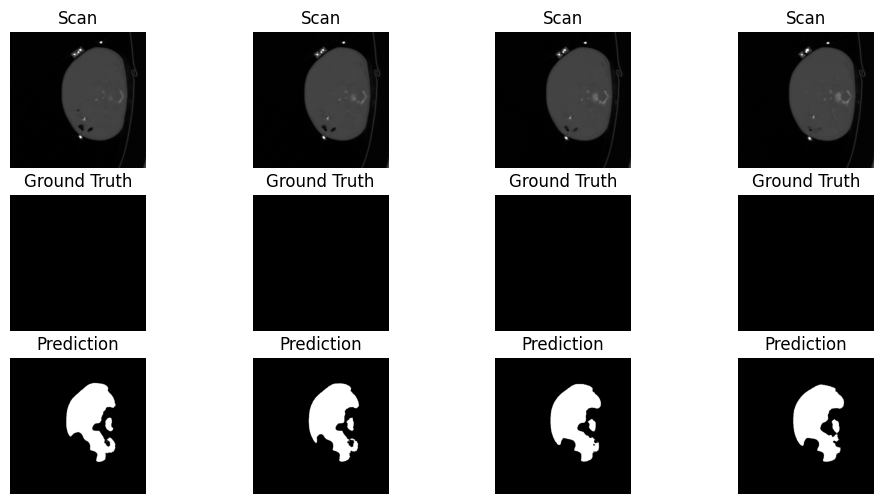

In [82]:
import matplotlib.pyplot as plt

# Test için bir örnek al
model.eval()
with torch.no_grad():
    for scans, masks in test_loader:
        scans, masks = scans.to(device), masks.to(device)
        outputs = model(scans)
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Tahmini binarize et
        break  # Sadece ilk batch'i al

# Görselleştirme
fig, axes = plt.subplots(3, len(scans), figsize=(12, 6))

for i in range(len(scans)):
    axes[0, i].imshow(scans[i, 0].cpu(), cmap="gray")  # Orijinal tarama
    axes[0, i].set_title("Scan")
    axes[0, i].axis("off")

    axes[1, i].imshow(masks[i, 0].cpu(), cmap="gray")  # Gerçek maske
    axes[1, i].set_title("Ground Truth")
    axes[1, i].axis("off")

    axes[2, i].imshow(preds[i, 0].cpu(), cmap="gray")  # Modelin tahmini
    axes[2, i].set_title("Prediction")
    axes[2, i].axis("off")

plt.show()


In [83]:
torch.save(model.state_dict(), "/content/drive/My Drive/vnet_model.pth")
print("Model başarıyla kaydedildi!")


Model başarıyla kaydedildi!


In [84]:
model.load_state_dict(torch.load("/content/drive/My Drive/vnet_model.pth"))
model.eval()
print("Model başarıyla yüklendi!")


Model başarıyla yüklendi!


<ipython-input-84-319e21b13573>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/My Drive/vnet_model.pth"))


In [86]:
!pip install opencv-python-headless
import cv2


In [87]:
blended = (scan * 0.6 + overlay_gt[:, :, 1] * 0.4).astype(np.uint8)  # Yeşil: Gerçek Maske
blended_pred = (scan * 0.6 + overlay_pred[:, :, 0] * 0.4).astype(np.uint8)  # Kırmızı: Model Tahmini


In [88]:
import numpy as np

# Orijinal Görüntü Üzerine Maske Çakıştırma (Overlay)
blended = (scan * 0.6 + overlay_gt[..., 1] * 0.4).astype(np.uint8)  # Yeşil: Gerçek Maske
blended_pred = (scan * 0.6 + overlay_pred[..., 0] * 0.4).astype(np.uint8)  # Kırmızı: Model Tahmini


In [90]:
print("Scan shape:", scan.shape)
print("Overlay_gt shape:", overlay_gt.shape)
print("Overlay_pred shape:", overlay_pred.shape)


Scan shape: (512, 512)
Overlay_gt shape: (512, 512, 3)
Overlay_pred shape: (512, 512, 3)


In [91]:
overlay_gt_resized = cv2.resize(overlay_gt, (scan.shape[1], scan.shape[0]))
overlay_pred_resized = cv2.resize(overlay_pred, (scan.shape[1], scan.shape[0]))


In [94]:
scan_rgb = cv2.cvtColor(scan, cv2.COLOR_GRAY2RGB)  # 3 kanallı hale getir


In [97]:
print("Scan RGB Shape:", scan_rgb.shape, "Type:", scan_rgb.dtype)
print("Overlay GT Shape:", overlay_gt.shape, "Type:", overlay_gt.dtype)
print("Overlay Pred Shape:", overlay_pred.shape, "Type:", overlay_pred.dtype)


Scan RGB Shape: (512, 512, 3) Type: float32
Overlay GT Shape: (512, 512, 3) Type: uint8
Overlay Pred Shape: (512, 512, 3) Type: uint8


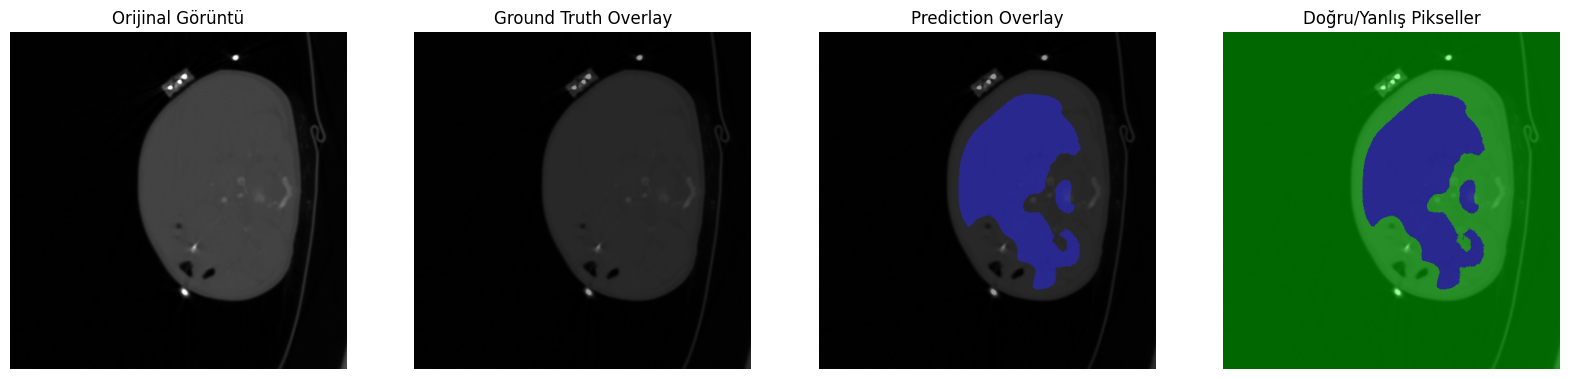

In [105]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Orijinal görüntüyü 0-255 ölçeğine çıkar ve uint8 formatına çevir
scan_rgb_uint8 = (scan_rgb * 255).astype(np.uint8)

# Boş bir hata haritası oluştur (RGB formatında)
error_map = np.zeros_like(overlay_gt, dtype=np.uint8)

# Boolean maskeler
correct_pixels = np.all(overlay_gt == overlay_pred, axis=-1)  # Tüm kanallarda eşleşme olup olmadığına bak
false_pixels = np.any(overlay_gt != overlay_pred, axis=-1)  # En az bir kanalda farklılık olup olmadığına bak

# Hata haritasına doğru ve yanlış pikselleri işle
error_map[..., 0][false_pixels] = 255  # Yanlış pikseller (Kırmızı: R=255, G=0, B=0)
error_map[..., 1][correct_pixels] = 255  # Doğru pikseller (Yeşil: R=0, G=255, B=0)

# Ağırlıklı görüntüleri oluştur
blended_gt = cv2.addWeighted(scan_rgb_uint8, 0.6, overlay_gt, 0.4, 0)
blended_pred = cv2.addWeighted(scan_rgb_uint8, 0.6, overlay_pred, 0.4, 0)
blended_error = cv2.addWeighted(scan_rgb_uint8, 0.6, error_map, 0.4, 0)

# Görselleri yan yana göster
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(scan_rgb_uint8, cv2.COLOR_BGR2RGB))  # OpenCV BGR formatında çalışır, RGB'ye çeviriyoruz
plt.title("Orijinal Görüntü")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(blended_gt, cv2.COLOR_BGR2RGB))
plt.title("Ground Truth Overlay")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(blended_pred, cv2.COLOR_BGR2RGB))
plt.title("Prediction Overlay")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(blended_error, cv2.COLOR_BGR2RGB))
plt.title("Doğru/Yanlış Pikseller")
plt.axis("off")

plt.show()


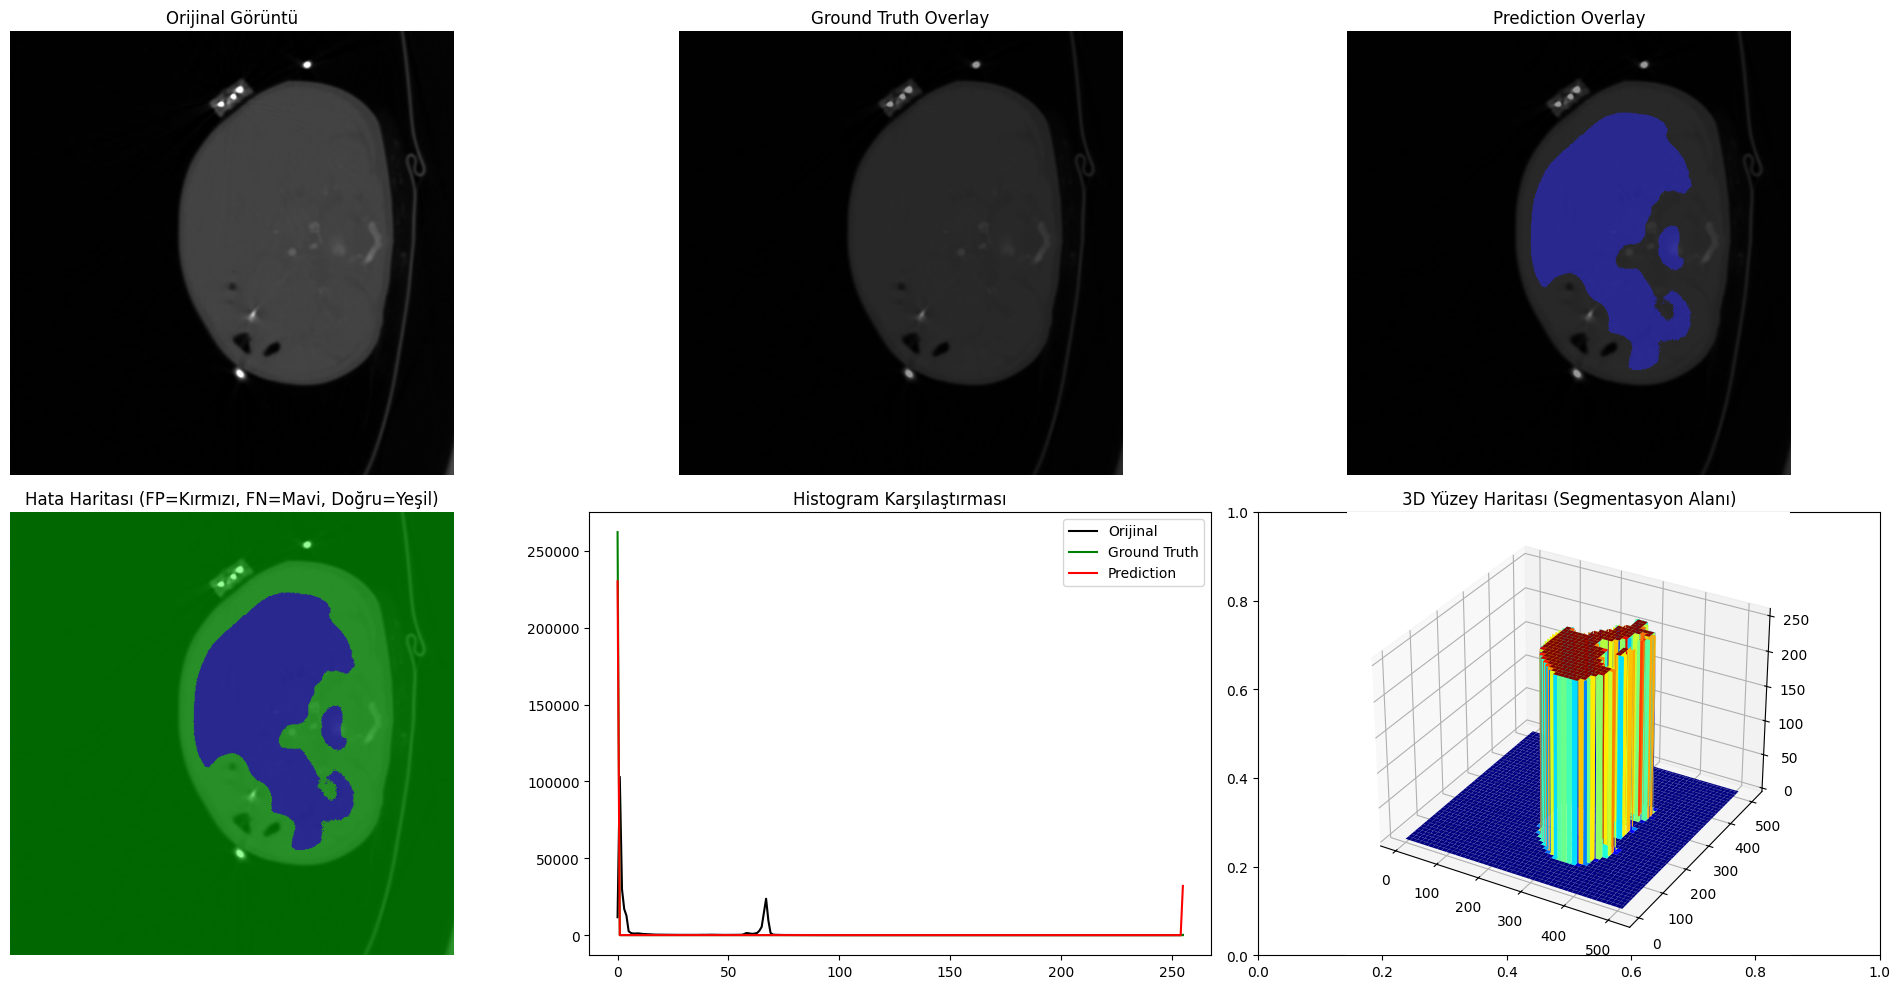

In [106]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Orijinal görüntüyü 0-255 ölçeğine çıkar ve uint8 formatına çevir
scan_rgb_uint8 = (scan_rgb * 255).astype(np.uint8)

# Hata haritası için boş bir görüntü oluştur
error_map = np.zeros_like(overlay_gt, dtype=np.uint8)

# Boolean maskeler
false_positive = (overlay_pred == 255) & (overlay_gt == 0)  # Yanlış Pozitif (FP) - Model var dedi ama yok
false_negative = (overlay_pred == 0) & (overlay_gt == 255)  # Yanlış Negatif (FN) - Model yok dedi ama var
correct_prediction = overlay_gt == overlay_pred  # Doğru tahmin edilenler

# Hata haritasına renkleri uygula
error_map[..., 0][false_positive[..., 0]] = 255  # Kırmızı: Yanlış Pozitif
error_map[..., 1][correct_prediction[..., 0]] = 255  # Yeşil: Doğru Tahmin
error_map[..., 2][false_negative[..., 0]] = 255  # Mavi: Yanlış Negatif

# Ağırlıklı görüntüleri oluştur
blended_gt = cv2.addWeighted(scan_rgb_uint8, 0.6, overlay_gt, 0.4, 0)
blended_pred = cv2.addWeighted(scan_rgb_uint8, 0.6, overlay_pred, 0.4, 0)
blended_error = cv2.addWeighted(scan_rgb_uint8, 0.6, error_map, 0.4, 0)

# Histogramlar
hist_scan = cv2.calcHist([scan_rgb_uint8], [0], None, [256], [0, 256])
hist_gt = cv2.calcHist([overlay_gt], [0], None, [256], [0, 256])
hist_pred = cv2.calcHist([overlay_pred], [0], None, [256], [0, 256])

# 3D Yüzey Haritası
X, Y = np.meshgrid(range(scan_rgb_uint8.shape[1]), range(scan_rgb_uint8.shape[0]))
Z = overlay_pred[:, :, 0]  # Maskeyi yükseklik olarak al

# Görselleri yan yana göster
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

axes[0, 0].imshow(cv2.cvtColor(scan_rgb_uint8, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title("Orijinal Görüntü")
axes[0, 0].axis("off")

axes[0, 1].imshow(cv2.cvtColor(blended_gt, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title("Ground Truth Overlay")
axes[0, 1].axis("off")

axes[0, 2].imshow(cv2.cvtColor(blended_pred, cv2.COLOR_BGR2RGB))
axes[0, 2].set_title("Prediction Overlay")
axes[0, 2].axis("off")

axes[1, 0].imshow(cv2.cvtColor(blended_error, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title("Hata Haritası (FP=Kırmızı, FN=Mavi, Doğru=Yeşil)")
axes[1, 0].axis("off")

# Histogram Analizi
axes[1, 1].plot(hist_scan, color="black", label="Orijinal")
axes[1, 1].plot(hist_gt, color="green", label="Ground Truth")
axes[1, 1].plot(hist_pred, color="red", label="Prediction")
axes[1, 1].set_title("Histogram Karşılaştırması")
axes[1, 1].legend()

# 3D Yüzey Haritası
ax3d = fig.add_subplot(2, 3, 6, projection="3d")
ax3d.plot_surface(X, Y, Z, cmap="jet")
ax3d.set_title("3D Yüzey Haritası (Segmentasyon Alanı)")

plt.tight_layout()
plt.show()


<ipython-input-109-8619beb352b0>:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2, 1].boxplot([scan_values, gt_values, pred_values], labels=["Orijinal", "Ground Truth", "Prediction"])


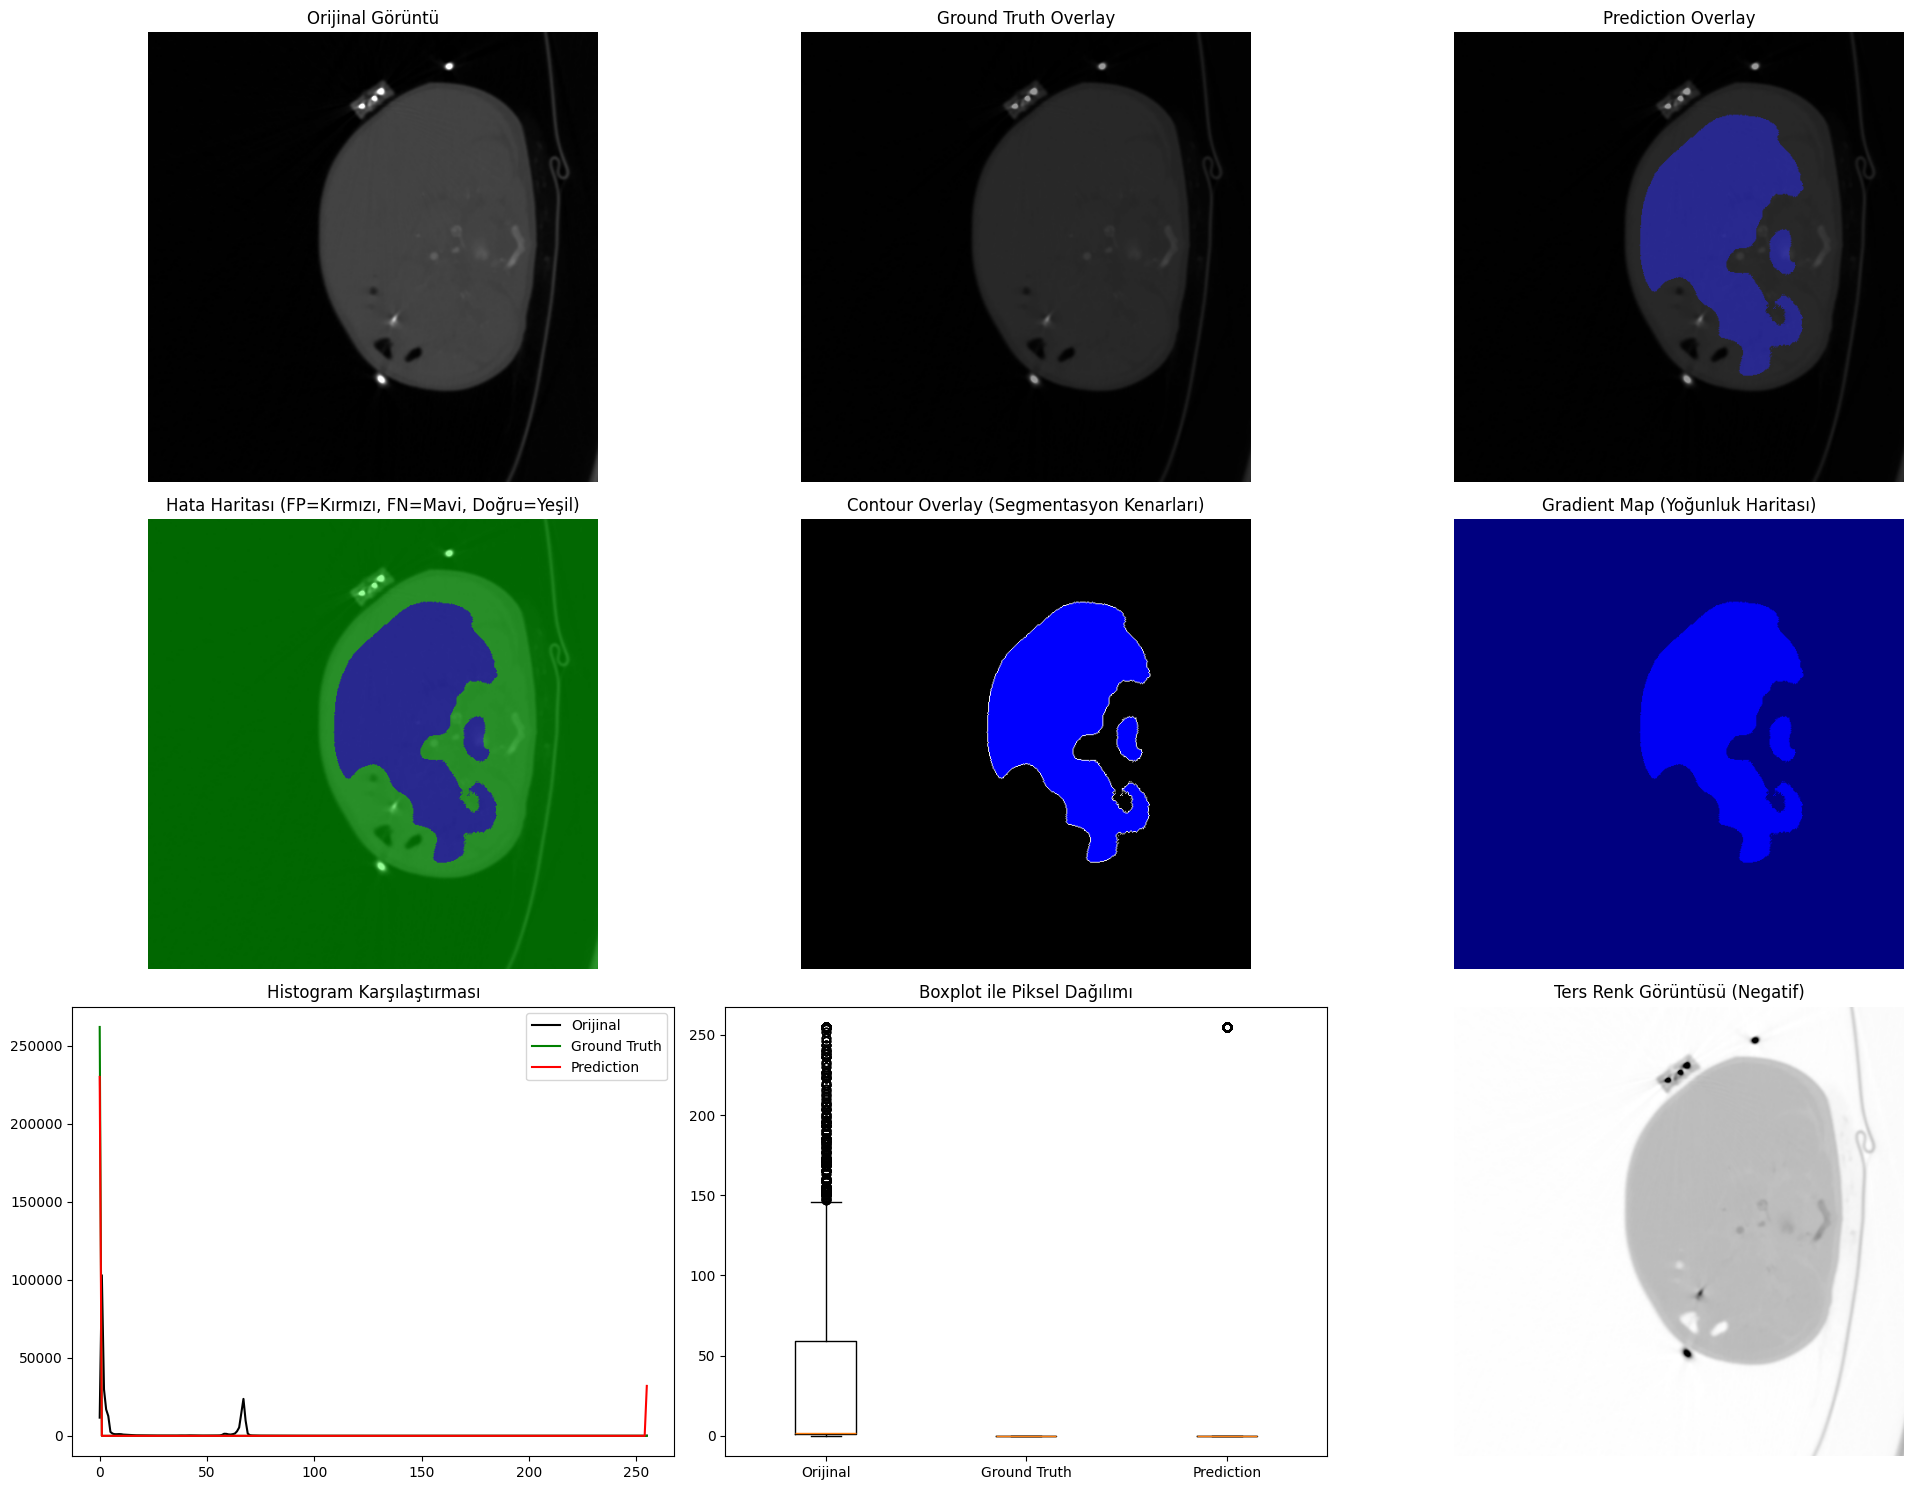

In [109]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Orijinal görüntüyü uygun formata çevir
scan_rgb_uint8 = (scan_rgb * 255).astype(np.uint8)

# Fark haritası (Error Map) için boş bir görüntü
error_map = np.zeros_like(overlay_gt, dtype=np.uint8)

# False Positive (Yanlış Pozitif) ve False Negative (Yanlış Negatif) Maskeleri
fp_mask = (overlay_pred == 255) & (overlay_gt == 0)  # Model yanlışlıkla segmentasyon yaptı
fn_mask = (overlay_pred == 0) & (overlay_gt == 255)  # Model segmentasyon yapmadı ama olmalıydı
correct_mask = overlay_gt == overlay_pred  # Doğru tahmin edilenler

# Hata haritasına renkleri uygula
error_map[..., 0][fp_mask[..., 0]] = 255  # Kırmızı: Yanlış Pozitif (FP)
error_map[..., 2][fn_mask[..., 0]] = 255  # Mavi: Yanlış Negatif (FN)
error_map[..., 1][correct_mask[..., 0]] = 255  # Yeşil: Doğru tahminler

# Kenarları belirginleştirmek için kontur çizme
overlay_contour = overlay_pred.copy()
contours, _ = cv2.findContours(overlay_pred[:, :, 0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(overlay_contour, contours, -1, (255, 255, 255), 1)

# Gradient Map (Yoğunluk Haritası) oluştur
gradient_map = cv2.applyColorMap(overlay_pred, cv2.COLORMAP_JET)

# Ağırlıklı görüntüleri oluştur
blended_gt = cv2.addWeighted(scan_rgb_uint8, 0.6, overlay_gt, 0.4, 0)
blended_pred = cv2.addWeighted(scan_rgb_uint8, 0.6, overlay_pred, 0.4, 0)
blended_error = cv2.addWeighted(scan_rgb_uint8, 0.6, error_map, 0.4, 0)

# Histogram Analizi
hist_scan = cv2.calcHist([scan_rgb_uint8], [0], None, [256], [0, 256])
hist_gt = cv2.calcHist([overlay_gt], [0], None, [256], [0, 256])
hist_pred = cv2.calcHist([overlay_pred], [0], None, [256], [0, 256])

# Boxplot için piksel değerlerini çıkar
gt_values = overlay_gt.flatten()
pred_values = overlay_pred.flatten()
scan_values = scan_rgb_uint8.flatten()

# Ters Renk Görüntüsü (Negatif Görselleştirme)
inverted_image = 255 - scan_rgb_uint8

# Görselleri oluştur
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# Orijinal ve Maske Karşılaştırmaları
axes[0, 0].imshow(cv2.cvtColor(scan_rgb_uint8, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title("Orijinal Görüntü")
axes[0, 0].axis("off")

axes[0, 1].imshow(cv2.cvtColor(blended_gt, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title("Ground Truth Overlay")
axes[0, 1].axis("off")

axes[0, 2].imshow(cv2.cvtColor(blended_pred, cv2.COLOR_BGR2RGB))
axes[0, 2].set_title("Prediction Overlay")
axes[0, 2].axis("off")

# Farklı Analiz Teknikleri
axes[1, 0].imshow(cv2.cvtColor(blended_error, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title("Hata Haritası (FP=Kırmızı, FN=Mavi, Doğru=Yeşil)")
axes[1, 0].axis("off")

axes[1, 1].imshow(cv2.cvtColor(overlay_contour, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title("Contour Overlay (Segmentasyon Kenarları)")
axes[1, 1].axis("off")

axes[1, 2].imshow(cv2.cvtColor(gradient_map, cv2.COLOR_BGR2RGB))
axes[1, 2].set_title("Gradient Map (Yoğunluk Haritası)")
axes[1, 2].axis("off")

# Histogram Analizi
axes[2, 0].plot(hist_scan, color="black", label="Orijinal")
axes[2, 0].plot(hist_gt, color="green", label="Ground Truth")
axes[2, 0].plot(hist_pred, color="red", label="Prediction")
axes[2, 0].set_title("Histogram Karşılaştırması")
axes[2, 0].legend()

# Boxplot Görselleştirmesi
axes[2, 1].boxplot([scan_values, gt_values, pred_values], labels=["Orijinal", "Ground Truth", "Prediction"])
axes[2, 1].set_title("Boxplot ile Piksel Dağılımı")

# Ters Renk Görselleştirme
axes[2, 2].imshow(cv2.cvtColor(inverted_image, cv2.COLOR_BGR2RGB))
axes[2, 2].set_title("Ters Renk Görüntüsü (Negatif)")
axes[2, 2].axis("off")

plt.tight_layout()
plt.show()
